## Spatial mapping

### UCL
#### Feng Yin

In this notebook we want to build a connnection between the coarse resolution and high resolution, which is based on our previous study, in which we built model based on the point spread function (PSF) to connnect those different spatial resolution data.

In [1]:
import numpy as np
import gdal
import pylab as plt 
from osgeo import osr
import itertools
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

#### Sentinel 2 UTM projection

In [2]:
ls /home/ucfafyi/DATA/S2_MODIS/s_data/50/S/KG/2016/4/13/0/ # Get some sentinel 2 data as the high resolution data

auxiliary/  B04.jp2  B08.jp2  B12.jp2       preview.jp2       tileInfo.json
B01.jp2     B05.jp2  B09.jp2  B8A.jp2       preview.jpg
B02.jp2     B06.jp2  B10.jp2  cloud.tif     productInfo.json
B03.jp2     B07.jp2  B11.jp2  metadata.xml  qi/


In [3]:
g = gdal.Open('/home/ucfafyi/DATA/S2_MODIS/s_data/50/S/KG/2016/4/13/0/B04.jp2')

To check the geo information of S2 data

In [4]:
raster_wkt = g.GetProjection()
spatial_ref = osr.SpatialReference()
spatial_ref.ImportFromWkt(raster_wkt)
print spatial_ref.ExportToPrettyWkt(), '\n', spatial_ref.ExportToProj4() 

PROJCS["WGS 84 / UTM zone 50N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AXIS["Latitude",NORTH],
        AXIS["Longitude",EAST],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32650"]] 
+proj=utm +zone=50 +datum=WGS84 +units=m +no_defs 


In [5]:
rester_wkt = g.GetProjection()
UTM = osr.SpatialReference()
UTM.ImportFromWkt(raster_wkt) # since Sentinel 2 contain the UTM projection information
wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code
tx = osr.CoordinateTransformation(UTM, wgs84)

geo_t = g.GetGeoTransform ()
x_size = g.RasterXSize # Raster xsize
y_size = g.RasterYSize # Raster ysize

# Work out the boundaries of the new dataset in the target projection
(ulx, uly, ulz ) = tx.TransformPoint( geo_t[0], geo_t[3])

(lrx, lry, lrz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                      geo_t[3] + geo_t[5]*y_size )

(llx, lly, llz ) = tx.TransformPoint( geo_t[0] , \
                                      geo_t[3] + geo_t[5]*y_size )

(urx, ury, urz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                      geo_t[3]  )


In [6]:
ulx, uly,lrx, lry,llx, lly,urx, ury,

(113.58802752133003,
 37.8980997872802,
 114.8639749541644,
 36.93866731107288,
 113.63258699687118,
 36.91011916105018,
 114.83567015867709,
 37.927680432881054)

#### MODIS Sinusoidal projection

And we check the MODIS geo information as well

In [7]:
ls /home/ucfafyi/DATA/S2_MODIS/m_data/MCD43A1.A2016002.h18v03.006.2016174083634.hdf

/home/ucfafyi/DATA/S2_MODIS/m_data/MCD43A1.A2016002.h18v03.006.2016174083634.hdf


In [8]:
g = gdal.Open('HDF4_EOS:EOS_GRID:"/home/ucfafyi/DATA/S2_MODIS/m_data/MCD43A1.A2016002.h18v03.006.2016174083634.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band1')
raster_wkt = g.GetProjection()
spatial_ref = osr.SpatialReference()
spatial_ref.ImportFromWkt(raster_wkt)
print spatial_ref.ExportToPrettyWkt(), '\n', spatial_ref.ExportToProj4() ,'\n', g.GetGeoTransform()

PROJCS["unnamed",
    GEOGCS["Unknown datum based upon the custom spheroid",
        DATUM["Not specified (based on custom spheroid)",
            SPHEROID["Custom spheroid",6371007.181,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Sinusoidal"],
    PARAMETER["longitude_of_center",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["Meter",1]] 
+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs  
(0.0, 463.3127165279167, 0.0, 6671703.118, 0.0, -463.3127165279165)


Since we want to get the pixels position, to do that we need to know the pxiels' width and hight. So we need to get the definition of modis Sinusoidal projection. 

From WIKI https://en.wikipedia.org/wiki/Sinusoidal_projection:

$$x = (\lambda -\lambda_0)* \cos{\varphi}$$
$$y = \varphi$$

$\varphi$ is the latitude, $\lambda$ is the longitude, and $\lambda_0$ is the central meridian. We now can get the x, y values in Sinusoidal projection. According to the Porj4 of Sinusoidal, +a=6371007.181 +b=6371007.181, means we need to times the scale factor to get the final x, y.

In [9]:
# here we can find the origins of MODIS Sinusoidal projection 
# by giving the starts and ends of latitude and longtitude
lat_s,lon_s = -90, -180
lat_e,lon_e = 90, 180
rho = 6371007.181
lambdaa_s, phi_s = lat_s*np.pi/180., lon_s*np.pi/180.
lambdaa_e, phi_e = lat_e*np.pi/180., lon_e*np.pi/180.

x_s, y_s = rho *lambdaa_s* np.cos(phi_s), rho * phi_s
x_e, y_e = rho *lambdaa_e* np.cos(phi_e), rho * phi_e
x_s, y_s, x_e, y_e, 

(10007554.677898709,
 -20015109.355797417,
 -10007554.677898709,
 20015109.355797417)

In [10]:
(x_e-x_s)/(2400.*18), (y_e-y_s)/(2400.*36)# and pixel widths in x and y direction

(-463.31271656938469, 463.3127165693847)

But the values are slightly different from what we get in the previous step where it shows for h18v07, the pixel width is 463.3127165279167 and -463.3127165274999. And the origins of x,y are also slightly different from the vlaues provided by NASA, which are -20015109.354,10007554.677, so another way to check it is open some files to get those values and see check if the pixel width changed a lot from tile to tile.

In [11]:
# we find all of the files in the local and get their pixels width and height
import glob
data = []
for h in range(1,37):
    for v in range(1,19):
        temp = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band1'
        fn = '/home/ucfafyi/DATA/S2_MODIS/m_data/MCD43A1.*.h%02dv%02d.006.*.hdf'
        fs = glob.glob(fn%(h,v))   
        if fs!=[]:
            g = gdal.Open(temp%fs[0])
            x_step, y_step = g.GetGeoTransform()[1], g.GetGeoTransform()[-1]
            data.append([v, x_step, h, y_step])
data

[[5, 463.31271652791725, 8, -463.3127165279167],
 [5, 463.31271652749973, 10, -463.3127165279167],
 [2, 463.3127165279169, 11, -463.3127165279169],
 [4, 463.3127165279169, 11, -463.31271652750013],
 [5, 463.3127165279169, 11, -463.3127165279167],
 [10, 463.3127165279169, 11, -463.3127165274999],
 [11, 463.31271652750013, 13, -463.3127165279167],
 [4, 463.3127165279167, 17, -463.31271652750013],
 [7, 463.3127165279167, 17, -463.3127165274999],
 [3, 463.3127165279167, 18, -463.3127165279165],
 [4, 463.3127165279167, 18, -463.31271652750013],
 [7, 463.3127165279167, 18, -463.3127165274999],
 [8, 463.3127165279167, 18, -463.3127165279167],
 [4, 463.3127165274999, 19, -463.31271652750013],
 [10, 463.3127165274999, 19, -463.3127165274999],
 [11, 463.3127165274999, 19, -463.3127165279167],
 [3, 463.31271652750013, 22, -463.3127165279165],
 [6, 463.31271652750013, 22, -463.3127165279167],
 [2, 463.3127165279169, 24, -463.3127165279169],
 [6, 463.3127165279169, 24, -463.3127165279167],
 [4, 463

In [12]:
np.array(data)

array([[   5.        ,  463.31271653,    8.        , -463.31271653],
       [   5.        ,  463.31271653,   10.        , -463.31271653],
       [   2.        ,  463.31271653,   11.        , -463.31271653],
       [   4.        ,  463.31271653,   11.        , -463.31271653],
       [   5.        ,  463.31271653,   11.        , -463.31271653],
       [  10.        ,  463.31271653,   11.        , -463.31271653],
       [  11.        ,  463.31271653,   13.        , -463.31271653],
       [   4.        ,  463.31271653,   17.        , -463.31271653],
       [   7.        ,  463.31271653,   17.        , -463.31271653],
       [   3.        ,  463.31271653,   18.        , -463.31271653],
       [   4.        ,  463.31271653,   18.        , -463.31271653],
       [   7.        ,  463.31271653,   18.        , -463.31271653],
       [   8.        ,  463.31271653,   18.        , -463.31271653],
       [   4.        ,  463.31271653,   19.        , -463.31271653],
       [  10.        ,  463.312716

We can see they changing with the tile number, but remmenber that the unit of width is meter and the magnitude is $10^{-8}$, which shoud be nano meter level....? Hence, we only need to fix the pixel width to be 463.31271653 for both diretion and use the NASA provided origins as our origins, as they may change it a little bit to get more precise geolocation for the pixels.......but I could not find the specification......

In [13]:
#a function transform between different projections....
def transform(a = 1):
    # from prof. lewis
    wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
    wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code
    modis_sinu = osr.SpatialReference() # define the SpatialReference object
    # In this case, we get the projection from a Proj4 string
    modis_sinu.ImportFromProj4 ( \
                    "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs")
    
    utm = osr.SpatialReference( )
    utm.ImportFromProj4 ('+proj=utm +zone=50 +datum=WGS84 +units=m +no_defs')
    # add more ....
    
    if a ==1:
        # from modis to wgs 84
        tx = osr.CoordinateTransformation(modis_sinu, wgs84)
    elif a == 2:
        # from wgs 84 to modis
        tx = osr.CoordinateTransformation(wgs84,modis_sinu)
    elif a == 3:
        # from wgs 84 to modis
        tx = osr.CoordinateTransformation(wgs84, utm)
    elif a == 4:
        tx = osr.CoordinateTransformation(utm, wgs84)
    # the following two transforms shold be tested before the usage....
    # generally WGS84 is reccommonded as the base to convert between
    # different projections
    elif a == 5:
        tx = osr.CoordinateTransformation(modis_sinu, utm)
    elif a == 6:
        tx = osr.CoordinateTransformation(utm, modis_sinu)
    # elif: 
    #   even more .....
    else:
        tx = 0
        
        print 'please define your own transformation....'
    
    return tx

In [14]:
# since we have the origins and the steps, we can write a function
# to calculate modis tile number with the lat and lon as the inputs
x_step = -463.31271653
y_step = 463.31271653
m_y0, m_x0 = -20015109.354, 10007554.677
def mtile_cal(lat, lon):
    # a function calculate the tile number for MODIS, based on the lat and lon
    tx = transform( a = 2)# from wgs84 to modis 
    ho,vo,z = tx.TransformPoint(lon, lat)# still use the function instead of using the equation....
    h = int((ho-m_y0)/(2400*y_step))
    v = int((vo-m_x0)/(2400*x_step))
    return h,v

In [15]:
# test it....
mtile_cal(37,114) # north China plain

(27, 5)

Then we can also buld a function to find the longtitude and latitude of each pixel in a modis tile, since the transformation from coarse resolution to high resolution would be much faster than the other way around. 

But let's first test the results is resonable or not.....

In [16]:
g = gdal.Open('HDF4_EOS:EOS_GRID:"/home/ucfafyi/DATA/S2_MODIS/m_data/MCD43A1.A2016002.h18v03.006.2016174083634.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band1')
rester_wkt = g.GetProjection()
UTM = osr.SpatialReference()
UTM.ImportFromWkt(raster_wkt) # since Sentinel 2 contain the UTM projection information
wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code
tx = osr.CoordinateTransformation(UTM, wgs84)

geo_t = g.GetGeoTransform ()
x_size = g.RasterXSize # Raster xsize
y_size = g.RasterYSize # Raster ysize

# Work out the boundaries of the new dataset in the target projection
(ulx, uly, ulz ) = tx.TransformPoint( geo_t[0], geo_t[3])

(lrx, lry, lrz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                      geo_t[3] + geo_t[5]*y_size )

(llx, lly, llz ) = tx.TransformPoint( geo_t[0] , \
                                      geo_t[3] + geo_t[5]*y_size )

(urx, ury, urz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                      geo_t[3]  )


In [17]:
ulx, uly, lrx, lry, llx, lly, urx, ury

(0.0,
 59.999999994611805,
 15.557238265757757,
 49.99999999550685,
 0.0,
 49.99999999550685,
 19.999999994952233,
 59.999999994611805)

In [18]:
h = 27; v=5
tx = transform(a=1) # from modis to wgs84
geo_t = g.GetGeoTransform ()
x_size = g.RasterXSize # Raster xsize
y_size = g.RasterYSize # Raster ysize

# Work out the boundaries of the new dataset in the target projection
x_size, y_size = 2400, 2400
geo_t0, geo_t3 = m_y0 + h*2400*y_step , m_x0 + v*2400*x_step

(ul_lon, ul_lat, ulz ) = tx.TransformPoint( geo_t0, geo_t3)

(lr_lon, lr_lat, lrz ) = tx.TransformPoint( geo_t0 + y_step*y_size, \
                                      geo_t3 + x_step*x_size )

(ll_lon, ll_lat, llz )  = tx.TransformPoint( geo_t0 , \
                                      geo_t3 + x_step*x_size )

(ur_lon, ur_lat, urz ) = tx.TransformPoint( geo_t0 + y_step*y_size, \
                                      geo_t3  )
(ul_lon, ul_lat), (lr_lon, lr_lat), (ll_lon, ll_lat), (ur_lon, ur_lat)

((117.48665602445169, 39.99999999616804),
 (115.47005382563678, 29.99999999701811),
 (103.92304844317277, 29.99999999701811),
 (130.54072891593225, 39.99999999616804))

We can see the corners coordinates calculated with the defult values are very close to those provided by the metedata of MODIS data. So we can use these values to easily do the conversion between Sinusoidal projections and other projections, mainly wgs84 and utm.

####  Geo_transformation

In stead of doing the geo transformation by using gdal, here a index method is proposed to get a more accurate and easier way to produce the mapping between different geographic systems. Actually, what we need to do is finding pixels having the same latitude and lontidude in two images.

In order to get the longtitude and latitude of MODIS pixel, we first get the four corners' coordinates in MODIS Sinusoidal projection and project them to longtitude and latitude. Then, a bilinear interpolation is used to get all points longtitude and latitude values.

In [19]:
def bilineanr(coords, dic, cors):
    
    '''
    basically a bilinear interpolation in matrix form (https://en.wikipedia.org/wiki/Bilinear_interpolation) 
    --------------------------------------------------------------------------------------------------------------
    coords is the coordinates [(x1, y1), (x2, y2)...] needed to transfer
    
    dic is a dictionary of the Upper lfet (UL), UR, LL, LR 's lat and lons
    
    example: dic ={'LL_LAT': 36.35288,
                   'LL_LON': 113.00651,
                   'LR_LAT': 36.41186,
                   'LR_LON': 115.6326,
                   'UL_LAT': 38.51077,
                   'UL_LON': 112.88999,
                   'UR_LAT': 38.57451,
                   'UR_LON': 115.59258}
    cors = {'ulx':ulx, 'llx': llx, 'urx': urx, 'lrx': lrx, 'uly': uly, 'lly': lly, 'ury': ury, 'lry': lry}
    
    corners is the (x, y) corresponding to the shape of the area (array)            
    '''
    
    a = np.matrix([[1, dic['UL_LAT'], dic['UL_LON'], dic['UL_LAT']*dic['UL_LON']],
                   [1, dic['LL_LAT'], dic['LL_LON'], dic['LL_LAT']*dic['LL_LON']],
                   [1, dic['UR_LAT'], dic['UR_LON'], dic['UR_LAT']*dic['UR_LON']],
                   [1, dic['LR_LAT'], dic['LR_LON'], dic['LR_LAT']*dic['LR_LON']],
                   ])
    
    convs = np.ones((4,len(coords[0])))
    convs[1] = coords[0]
    convs[2] = coords[1] 
    convs[3] = (coords[0]* coords[1])
    convs = np.matrix(convs)

    x = np.matrix([cors['ulx'], cors['llx'], cors['urx'], cors['lrx']])*((a**-1).T)*convs
    y = np.matrix([cors['uly'], cors['lly'], cors['ury'], cors['lry']])*((a**-1).T)*convs
    
    return np.array(x).ravel(), np.array(y).ravel()

In [20]:
# now we get all of the latitudes and longtitudes
# the fasest way to make x and y index of a image
xs = np.arange(0,2400).repeat(2400)
ys = np.tile(np.arange(0,2400), 2400)
coords = [xs,ys]
# the corners' latitudes and longtitudes
cors = {'ulx':ul_lat, 'llx': ll_lat, 'urx': ur_lat, 'lrx': lr_lat,\
        'uly': ul_lon, 'lly': ll_lon, 'ury': ur_lon, 'lry': lr_lon}

# corners coordinate in image
dic ={'UR_LAT': 0,
       'UR_LON': 2399,
       'LR_LAT': 2399,
       'LR_LON': 2399,
       'UL_LAT': 0,
       'UL_LON': 0,
       'LL_LAT': 2399,
       'LL_LON': 0}

latitudes, longtitudes = bilineanr(coords, dic, cors)

/home/ucfafyi/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


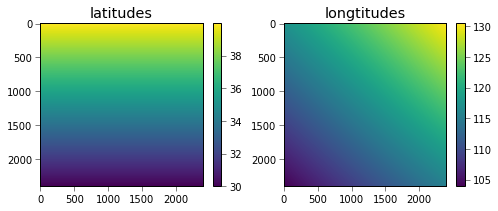

In [21]:
# visualise it...
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(1,2,1)
im = ax1.imshow(latitudes.reshape(2400,2400), interpolation='None')
fig.colorbar(im, ax=ax1)
ax1.title.set_text('latitudes')
ax2 = fig.add_subplot(1,2,2)
im = ax2.imshow(longtitudes.reshape(2400,2400), interpolation='None')
fig.colorbar(im, ax=ax2)
ax2.title.set_text('longtitudes')

In [22]:
x_step = -463.31271653
y_step = 463.31271653
m_y0, m_x0 = -20015109.354, 10007554.677

In [23]:
# this is the old way of doing it
# by transform point by point
h,v= 27,5
v0,h0 = m_x0+2400*v*x_step, m_y0+2400*h*y_step
v1, h1 = m_x0 + (v+1)*x_step *2400, (h+1)*y_step*2400 + m_y0
hs = np.arange(h0,h1,(h1-h0)/2400.)# The last coordinates should not included
vs = np.arange(v0,v1,(v1-v0)/2400.)
h_array = np.tile(hs, 2400)
v_array = np.repeat(vs, 2400)
wgs = np.array(tx.TransformPoints(np.array([h_array, v_array]).T))

In [25]:
def get_m_corners(h,v):
    tx = transform(a=1) # from modis to wgs84
    # Work out the boundaries of the new dataset in the target projection
    x_size, y_size = 2400, 2400
    geo_t0, geo_t3 = m_y0 + h*2400*y_step , m_x0 + v*2400*x_step

    (ul_lon, ul_lat, ulz ) = tx.TransformPoint( geo_t0, geo_t3)

    (lr_lon, lr_lat, lrz ) = tx.TransformPoint( geo_t0 + y_step*y_size, \
                                          geo_t3 + x_step*x_size )

    (ll_lon, ll_lat, llz )  = tx.TransformPoint( geo_t0 , \
                                          geo_t3 + x_step*x_size )

    (ur_lon, ur_lat, urz ) = tx.TransformPoint( geo_t0 + y_step*y_size, \
                                          geo_t3  )
    
    return ul_lon, ul_lat, lr_lon, lr_lat, ll_lon, ll_lat, ur_lon, ur_lat

In [26]:
# this is the new way
pix_num=2400
m_dic ={'UR_LAT': 0,
       'UR_LON': pix_num-1,
       'LR_LAT': pix_num-1,
       'LR_LON': pix_num-1,
       'UL_LAT': 0,
       'UL_LON': 0,
       'LL_LAT': pix_num-1,
       'LL_LON': 0}
xs = np.arange(0,pix_num).repeat(pix_num)
ys = np.tile(np.arange(0,pix_num), pix_num)
m_coords = [xs,ys]
m_cors = get_m_corners(27,5)
m_corners = dict(zip(['uly', 'ulx', 'lry', 'lrx', 'lly', 'llx', 'ury', 'urx'], m_cors))
latitudes, longtitudes = bilineanr(m_coords, m_dic, m_corners)

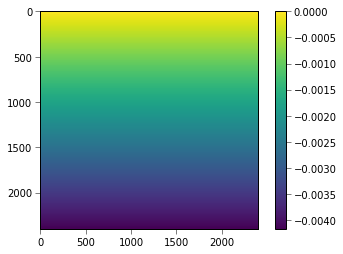

In [27]:
# when we compare then...
plt.imshow(latitudes.reshape(2400,2400) - wgs[:,1].reshape(2400,2400), interpolation='None')
plt.colorbar()

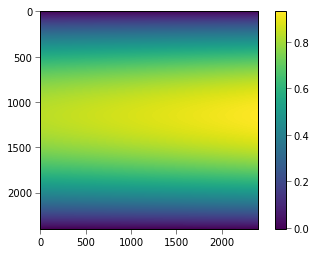

In [28]:
plt.imshow(longtitudes.reshape(2400,2400) - wgs[:,0].reshape(2400,2400), interpolation='None')
plt.colorbar()

Then we can see the difference is too big, which means the bilinear interpolation can not be used for the interpolation of MODIS longtitude and latitude since the distortion of MODIS longtitudes is too big and we have to use the previous geo-transformation.

In [29]:
# define a function
x_step = -463.31271653
y_step = 463.31271653
m_y0, m_x0 = -20015109.354, 10007554.677
def get_Mpix_wgs(h,v):
    tx = transform(a=1)
    v0,h0 = m_x0+2400*v*x_step, m_y0+2400*h*y_step
    v1, h1 = m_x0 + (v+1)*x_step *2400, (h+1)*y_step*2400 + m_y0
    hs = np.arange(h0,h1,(h1-h0)/2400.)# The last coordinates should not included
    vs = np.arange(v0,v1,(v1-v0)/2400.)
    h_array = np.tile(hs, 2400)
    v_array = np.repeat(vs, 2400)
    wgs = np.array(tx.TransformPoints(np.array([h_array, v_array]).T))
    return wgs

A nice pattein of the latitude and longtitude change within a MODIS tile...

To think about transform between different projection, we also need to think about the issures of the image in one projection covering mitliple tile in another image. Since the relative small amount of values need to be transformed from coarse resolution and there is no need for the sampling process. The transformation from high resolution to coarse resolution is need to be dealt with carefully.

In [30]:
# we check the sentinel 2 geoinformation again 
g = gdal.Open('/home/ucfafyi/DATA/S2_MODIS/s_data/50/S/KG/2016/4/13/0/B04.jp2')
geo_t = g.GetGeoTransform()
x_size, y_size = g.RasterXSize, g.RasterYSize
tx = transform(a=4)

# so we need the four corners coordiates to check whether they are within the same modis tile
(ul_lon, ul_lat, ulz ) = tx.TransformPoint( geo_t[0], geo_t[3])

(lr_lon, lr_lat, lrz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                      geo_t[3] + geo_t[5]*y_size )

(ll_lon, ll_lat, llz ) = tx.TransformPoint( geo_t[0] , \
                                      geo_t[3] + geo_t[5]*y_size )

(ur_lon, ur_lat, urz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                      geo_t[3]  )

print (ul_lon, ul_lat), (lr_lon, lr_lat), (ll_lon, ll_lat), (ur_lon, ur_lat)

(113.58802752133003, 37.8980997872802) (114.8639749541644, 36.93866731107288) (113.63258699687118, 36.91011916105018) (114.83567015867709, 37.927680432881054)


In [31]:
x_step = -463.31271653
y_step = 463.31271653
m_y0, m_x0 = -20015109.354, 10007554.677
def mtile_cal(lat, lon):
    # a function calculate the tile number for MODIS, based on the lat and lon
    tx = transform( a = 2)# from wgs84 to modis 
    ho,vo,z = tx.TransformPoint(lon, lat)# still use the function instead of using the equation....
    h = int((ho-m_y0)/(2400*y_step))
    v = int((vo-m_x0)/(2400*x_step))
    return h,v

for i in [(ul_lon, ul_lat), (lr_lon, lr_lat), (ll_lon, ll_lat), (ur_lon, ur_lat)]:
    print mtile_cal(i[1], i[0])

(26, 5)
(27, 5)
(27, 5)
(27, 5)


So there are some abnormal values......which gives us indication that this S2 image covers multiple modis tiles. So we need to split the S2 image based into two parts....

In [32]:
# to make it a more general method for further usage
a0, b0 = None, None
corners = [(ul_lon, ul_lat), (lr_lon, lr_lat), (ll_lon, ll_lat), (ur_lon, ur_lat)]
tiles = []
for i,j  in enumerate(corners):
    h,v = mtile_cal(j[1], j[0])
    if (h==a0) &(v==b0):
        pass
    else:
        tiles.append([i,h,v]) # o--ul;1--lr;2--ll;3--ur
        a0, b0 = h,v
print tiles # now we are able to find out the tiles that S2 image covers

[[0, 26, 5], [1, 27, 5]]


In [33]:
h = tiles[0][1]; v= tiles[0][2]
tx = transform(a=1) # from modis to wgs84
geo_t = g.GetGeoTransform ()
x_size = g.RasterXSize # Raster xsize
y_size = g.RasterYSize # Raster ysize

x_size, y_size = 2400, 2400
geo_t0, geo_t3 = m_y0 + h*2400*y_step , m_x0 + v*2400*x_step

(ulx, uly, ulz ) = tx.TransformPoint( geo_t0, geo_t3)

(lrx, lry, lrz ) = tx.TransformPoint( geo_t0 + y_step*y_size, \
                                      geo_t3 + x_step*x_size )

(llx, lly, llz ) = tx.TransformPoint( geo_t0 , \
                                      geo_t3 + x_step*x_size )

(urx, ury, urz ) = tx.TransformPoint( geo_t0 + y_step*y_size, \
                                      geo_t3  )
ulx, uly, lrx, lry, llx, lly, urx, ury

(104.43258313297117,
 39.99999999616804,
 103.92304844317276,
 29.99999999701811,
 92.37604306070877,
 29.99999999701811,
 117.48665602445169,
 39.99999999616804)

In [34]:
h = tiles[1][1]; v= tiles[1][2]

In [35]:
cors = get_m_corners(tiles[0][1],tiles[0][2])
corners = dict(zip(['uly', 'ulx', 'lry', 'lrx', 'lly', 'llx', 'ury', 'urx'], cors))

In [36]:
wgs

array([[ 117.48665602,   40.        ,    0.        ],
       [ 117.49209522,   40.        ,    0.        ],
       [ 117.49753442,   40.        ,    0.        ],
       ..., 
       [ 115.46046811,   30.00416666,    0.        ],
       [ 115.46527956,   30.00416666,    0.        ],
       [ 115.47009102,   30.00416666,    0.        ]])

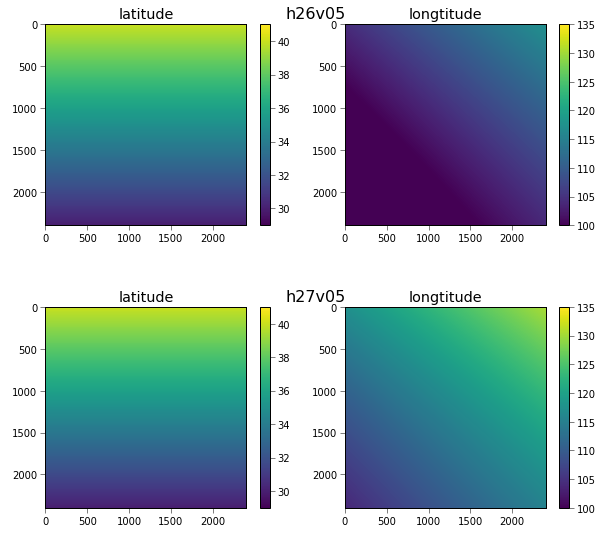

In [37]:
# the modis tiles covered by S2
n = len(tiles)
fig, big_axes = plt.subplots( figsize=(9,4*n) , nrows=2, ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes.ravel(), start=1):
    big_ax.set_title("h%02dv%02d" % (tiles[row-1][1], tiles[row-1][2]), fontsize=16)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False

for _,i in enumerate(tiles):
    latitudes, longtitudes = get_Mpix_wgs(i[1], i[2]).T[[1,0],]
    ax1 = fig.add_subplot(n,2,2*_+1)
    im = ax1.imshow(latitudes.reshape(2400,2400), interpolation='None', vmin=29, vmax=41)
    fig.colorbar(im, ax=ax1)
    ax2 = fig.add_subplot(n,2,2*_+2)
    im = ax2.imshow(longtitudes.reshape(2400,2400), interpolation='None', vmin=100, vmax=135)
    fig.colorbar(im, ax=ax2)
    ax1.title.set_text('latitude')
    ax2.title.set_text('longtitude')
plt.tight_layout()

Now we are able to convert each modis tiles, covered by S2 tile, to wgs84 coordinates. So we need to find those pixels are actually within S2 tile, and find the corresponding indexes in S2 and MODIS. 

It's time to find the MODIS pixels within a S2 tile....

In [38]:
g = gdal.Open('/home/ucfafyi/DATA/S2_MODIS/s_data/50/S/KG/2016/4/13/0/B04.jp2')
geo_t = g.GetGeoTransform()
x_size, y_size = g.RasterXSize, g.RasterYSize
tx = transform(a=4)

# so we need the four corners coordiates to check whether they are within the same modis tile
(ul_lon, ul_lat, ulz ) = tx.TransformPoint( geo_t[0], geo_t[3])

(lr_lon, lr_lat, lrz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                      geo_t[3] + geo_t[5]*y_size )

(ll_lon, ll_lat, llz ) = tx.TransformPoint( geo_t[0] , \
                                      geo_t[3] + geo_t[5]*y_size )

(ur_lon, ur_lat, urz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                      geo_t[3]  )

print (ul_lon, ul_lat), (lr_lon, lr_lat), (ll_lon, ll_lat), (ur_lon, ur_lat)

(113.58802752133003, 37.8980997872802) (114.8639749541644, 36.93866731107288) (113.63258699687118, 36.91011916105018) (114.83567015867709, 37.927680432881054)


In [39]:
#s2 corners latitudes and longtitudes
dic ={'UR_LAT': ur_lat,
       'UR_LON': ur_lon,
       'LR_LAT': lr_lat,
       'LR_LON': lr_lon,
       'UL_LAT': ul_lat,
       'UL_LON': ul_lon,
       'LL_LAT': ll_lat,
       'LL_LON': ll_lon}
dic

{'LL_LAT': 36.91011916105018,
 'LL_LON': 113.63258699687118,
 'LR_LAT': 36.93866731107288,
 'LR_LON': 114.8639749541644,
 'UL_LAT': 37.8980997872802,
 'UL_LON': 113.58802752133003,
 'UR_LAT': 37.927680432881054,
 'UR_LON': 114.83567015867709}

In [40]:
coords = [latitudes, longtitudes]
cors = ulx, uly, lrx, lry, llx, lly, urx, ury = 0,0,x_size, y_size, x_size,0, 0, y_size 
corners = dict(zip(['ulx', 'uly', 'lrx', 'lry', 'llx', 'lly', 'urx', 'ury'], cors))
corners

{'llx': 10980,
 'lly': 0,
 'lrx': 10980,
 'lry': 10980,
 'ulx': 0,
 'uly': 0,
 'urx': 0,
 'ury': 10980}

In [41]:
ulx, llx, urx, lrx, uly, lly, ury, lry

(0, 10980, 0, 10980, 0, 0, 10980, 10980)

In [42]:
cors = bilineanr([latitudes, longtitudes], dic, corners)
hinds =np.array([cors[0][(cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)],
                 cors[1][(cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)]]).astype(int)
minds = np.where(((cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)).reshape((2400,2400)))

In [43]:
print 'h%02dv%02d \n'%(h,v), hinds,'\n', np.array(minds)

h27v05 
[[    0     1     3 ..., 10977 10978 10979]
 [ 9994 10040 10087 ...,   823   870   916]] 
[[498 498 498 ..., 741 741 741]
 [119 120 121 ..., 223 224 225]]


In [44]:
hinds.shape

(2, 52915)

In [45]:
np.array(minds).shape

(2, 52915)

So now we are able to find the corresponding pixels in S2 and MODIS tile. Apply the same method to other MODIS tile to get those S2 pixels within MODIS.

In [46]:
# we check the sentinel 2 geoinformation again 
g = gdal.Open('/home/ucfafyi/DATA/S2_MODIS/s_data/50/S/KG/2016/4/13/0/B04.jp2')
geo_t = g.GetGeoTransform()
x_size, y_size = g.RasterXSize, g.RasterYSize
tx = transform(a=4)

# so we need the four corners coordiates to check whether they are within the same modis tile
(ul_lon, ul_lat, ulz ) = tx.TransformPoint( geo_t[0], geo_t[3])

(lr_lon, lr_lat, lrz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                      geo_t[3] + geo_t[5]*y_size )

(ll_lon, ll_lat, llz ) = tx.TransformPoint( geo_t[0] , \
                                      geo_t[3] + geo_t[5]*y_size )

(ur_lon, ur_lat, urz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                      geo_t[3]  )

print (ul_lon, ul_lat), (lr_lon, lr_lat), (ll_lon, ll_lat), (ur_lon, ur_lat)
# now its the s2 corners latitudes and longtitudes
s_dic ={'UR_LAT': ur_lat,
       'UR_LON': ur_lon,
       'LR_LAT': lr_lat,
       'LR_LON': lr_lon,
       'UL_LAT': ul_lat,
       'UL_LON': ul_lon,
       'LL_LAT': ll_lat,
       'LL_LON': ll_lon}
s_cors = ulx, uly, lrx, lry, llx, lly, urx, ury = 0,0,x_size, y_size, x_size,0, 0, y_size 
s_corners = dict(zip(['ulx', 'uly', 'lrx', 'lry', 'llx', 'lly', 'urx', 'ury'], s_cors))

(113.58802752133003, 37.8980997872802) (114.8639749541644, 36.93866731107288) (113.63258699687118, 36.91011916105018) (114.83567015867709, 37.927680432881054)


In [47]:
%%time
inds = {}
for i in tiles:
    
    latitudes, longtitudes = get_Mpix_wgs(i[1], i[2]).T[[1,0],]
    
    cors = bilineanr([latitudes, longtitudes], s_dic, s_corners)
    
    hinds =np.array([cors[0][(cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)],
                 cors[1][(cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)]]).astype(int)
    minds = np.where(((cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)).reshape((2400,2400)))
    inds['h%02dv%02d'%(i[1],i[2])] = [hinds, np.array(minds)]
print '0'

0
CPU times: user 13.3 s, sys: 7.02 s, total: 20.3 s
Wall time: 12.6 s


In [48]:
inds

{'h26v05': [array([[   0,    1,    3, ..., 3174, 3176, 3220],
         [3817, 3863, 3910, ...,   20,   67,    9]]),
  array([[ 502,  502,  502, ...,  573,  573,  574],
         [2391, 2392, 2393, ..., 2398, 2399, 2399]])],
 'h27v05': [array([[    0,     1,     3, ..., 10977, 10978, 10979],
         [ 9994, 10040, 10087, ...,   823,   870,   916]]),
  array([[498, 498, 498, ..., 741, 741, 741],
         [119, 120, 121, ..., 223, 224, 225]])]}

To wrap it up.....

In [49]:
# The input, a SENTINEL2 tile
# we check the sentinel 2 geoinformation again 
g = gdal.Open('/home/ucfafyi/DATA/S2_MODIS/s_data/50/S/KG/2016/4/13/0/B04.jp2')
geo_t = g.GetGeoTransform()
x_size, y_size = g.RasterXSize, g.RasterYSize
tx = transform(a=4)

# so we need the four corners coordiates to check whether they are within the same modis tile
(ul_lon, ul_lat, ulz ) = tx.TransformPoint( geo_t[0], geo_t[3])

(lr_lon, lr_lat, lrz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                      geo_t[3] + geo_t[5]*y_size )

(ll_lon, ll_lat, llz ) = tx.TransformPoint( geo_t[0] , \
                                      geo_t[3] + geo_t[5]*y_size )

(ur_lon, ur_lat, urz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                      geo_t[3]  )

#print (ul_lon, ul_lat), (lr_lon, lr_lat), (ll_lon, ll_lat), (ur_lon, ur_lat)
# now its the s2 corners latitudes and longtitudes
s_dic ={'UR_LAT': ur_lat,
       'UR_LON': ur_lon,
       'LR_LAT': lr_lat,
       'LR_LON': lr_lon,
       'UL_LAT': ul_lat,
       'UL_LON': ul_lon,
       'LL_LAT': ll_lat,
       'LL_LON': ll_lon}
s_cors = ulx, uly, lrx, lry, llx, lly, urx, ury = 0,0,x_size, y_size, x_size,0, 0, y_size 
s_corners = dict(zip(['ulx', 'uly', 'lrx', 'lry', 'llx', 'lly', 'urx', 'ury'], s_cors))

In [50]:
# find out the modis tiles
a0, b0 = None, None
corners = [(ul_lon, ul_lat), (lr_lon, lr_lat), (ll_lon, ll_lat), (ur_lon, ur_lat)]
tiles = []
for i,j  in enumerate(corners):
    h,v = mtile_cal(j[1], j[0])
    if (h==a0) &(v==b0):
        pass
    else:
        tiles.append([i,h,v]) # o--ul;1--lr;2--ll;3--ur
        a0, b0 = h,v
print tiles # now we are able to find out the tiles that S2 image covers

[[0, 26, 5], [1, 27, 5]]


In [51]:
# get the corresponding indexes
inds = {}
for i in tiles:
    latitudes, longtitudes = get_Mpix_wgs(i[1], i[2]).T[[1,0],]
    cors = bilineanr([latitudes, longtitudes], s_dic, s_corners)
    
    hinds =np.array([cors[0][(cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)],
                 cors[1][(cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)]]).astype(int)
    minds = np.where(((cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)).reshape((2400,2400)))
    inds['h%02dv%02d'%(i[1],i[2])] = [hinds, np.array(minds)]

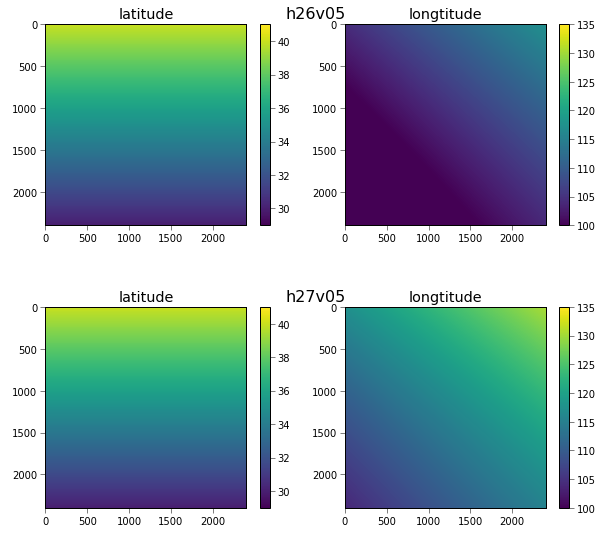

In [52]:
# or make plot the longtitude and latitude for checking purpose
n = len(tiles)
fig, big_axes = plt.subplots( figsize=(9,4*n) , nrows=2, ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes.ravel(), start=1):
    big_ax.set_title("h%02dv%02d" % (tiles[row-1][1], tiles[row-1][2]), fontsize=16)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
    
    
inds = {}
for _,i in enumerate(tiles):
    latitudes, longtitudes = get_Mpix_wgs(i[1], i[2]).T[[1,0],]
    ax1 = fig.add_subplot(n,2,2*_+1)
    im = ax1.imshow(latitudes.reshape(2400,2400), interpolation='None', vmin=29, vmax=41)
    fig.colorbar(im, ax=ax1)
    ax2 = fig.add_subplot(n,2,2*_+2)
    im = ax2.imshow(longtitudes.reshape(2400,2400), interpolation='None', vmin=100, vmax=135)
    fig.colorbar(im, ax=ax2)
    ax1.title.set_text('latitude')
    ax2.title.set_text('longtitude')

    cors = bilineanr([latitudes, longtitudes], s_dic, s_corners)
    
    hinds =np.array([cors[0][(cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)],
                 cors[1][(cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)]]).astype(int)
    minds = np.where(((cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)).reshape((2400,2400)))
    inds['h%02dv%02d'%(i[1],i[2])] = [hinds, np.array(minds)]
plt.tight_layout()

#### Functions:

In [53]:
#a function transform between different projections....
from osgeo import osr
import numpy as np
import gdal
def transform(a = 1):
    # from prof. lewis
    wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
    wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code
    modis_sinu = osr.SpatialReference() # define the SpatialReference object
    # In this case, we get the projection from a Proj4 string
    modis_sinu.ImportFromProj4 ( \
                    "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs")
    
    utm = osr.SpatialReference( )
    utm.ImportFromProj4 ('+proj=utm +zone=50 +datum=WGS84 +units=m +no_defs')
    # add more ....
    
    if a ==1:
        # from modis to wgs 84
        tx = osr.CoordinateTransformation(modis_sinu, wgs84)
    elif a == 2:
        # from wgs 84 to modis
        tx = osr.CoordinateTransformation(wgs84,modis_sinu)
    elif a == 3:
        # from wgs 84 to modis
        tx = osr.CoordinateTransformation(wgs84, utm)
    elif a == 4:
        tx = osr.CoordinateTransformation(utm, wgs84)
    # the following two transforms shold be tested before the usage....
    # generally WGS84 is reccommonded as the base to convert between
    # different projections
    elif a == 5:
        tx = osr.CoordinateTransformation(modis_sinu, utm)
    elif a == 6:
        tx = osr.CoordinateTransformation(utm, modis_sinu)
    # elif: 
    #   even more .....
    else:
        tx = 0
        
        print 'please define your own transformation....'
    
    return tx
# since we have the origins and the steps, we can write a function
# to calculate modis tile number with the lat and lon as the inputs




x_step = -463.31271653
y_step = 463.31271653
m_y0, m_x0 = -20015109.354, 10007554.677
def mtile_cal(lat, lon):
    # a function calculate the tile number for MODIS, based on the lat and lon
    tx = transform( a = 2)# from wgs84 to modis 
    ho,vo,z = tx.TransformPoint(lon, lat)# still use the function instead of using the equation....
    h = int((ho-m_y0)/(2400*y_step))
    v = int((vo-m_x0)/(2400*x_step))
    return h,v

def get_Mpix_wgs(h,v, pix_num):
    tx = transform(a=1)
    v0,h0 = m_x0+2400*v*x_step, m_y0+2400*h*y_step
    v1, h1 = m_x0 + (v+1)*x_step *2400, (h+1)*y_step*2400 + m_y0
    hs = np.arange(h0,h1,(h1-h0)/pix_num)# The last coordinates should not included
    vs = np.arange(v0,v1,(v1-v0)/pix_num)
    h_array = np.tile(hs, pix_num)
    v_array = np.repeat(vs, pix_num)
    wgs = np.array(tx.TransformPoints(np.array([h_array, v_array]).T))
    return wgs

def get_m_corners(h,v):
    tx = transform(a=1) # from modis to wgs84
    # Work out the boundaries of the new dataset in the target projection
    x_size, y_size = 2400, 2400
    geo_t0, geo_t3 = m_y0 + h*2400*y_step , m_x0 + v*2400*x_step

    (ul_lon, ul_lat, ulz ) = tx.TransformPoint( geo_t0, geo_t3)

    (lr_lon, lr_lat, lrz ) = tx.TransformPoint( geo_t0 + y_step*y_size, \
                                          geo_t3 + x_step*x_size )

    (ll_lon, ll_lat, llz )  = tx.TransformPoint( geo_t0 , \
                                          geo_t3 + x_step*x_size )

    (ur_lon, ur_lat, urz ) = tx.TransformPoint( geo_t0 + y_step*y_size, \
                                          geo_t3  )
    
    return ul_lon, ul_lat, lr_lon, lr_lat, ll_lon, ll_lat, ur_lon, ur_lat


def bilineanr(coords, dic, cors):
    
    '''
    basically a bilinear interpolation in matrix form (https://en.wikipedia.org/wiki/Bilinear_interpolation) 
    --------------------------------------------------------------------------------------------------------------
    coords is the coordinates [(x1, y1), (x2, y2)...] needed to transfer
    
    dic is a dictionary of the Upper lfet (UL), UR, LL, LR 's lat and lons
    
    example: dic ={'LL_LAT': 36.35288,
                   'LL_LON': 113.00651,
                   'LR_LAT': 36.41186,
                   'LR_LON': 115.6326,
                   'UL_LAT': 38.51077,
                   'UL_LON': 112.88999,
                   'UR_LAT': 38.57451,
                   'UR_LON': 115.59258}
    cors = {'ulx':ulx, 'llx': llx, 'urx': urx, 'lrx': lrx, 'uly': uly, 'lly': lly, 'ury': ury, 'lry': lry}
    
    corners is the (x, y) corresponding to the shape of the area (array)            
    '''
    
    a = np.matrix([[1, dic['UL_LAT'], dic['UL_LON'], dic['UL_LAT']*dic['UL_LON']],
                   [1, dic['LL_LAT'], dic['LL_LON'], dic['LL_LAT']*dic['LL_LON']],
                   [1, dic['UR_LAT'], dic['UR_LON'], dic['UR_LAT']*dic['UR_LON']],
                   [1, dic['LR_LAT'], dic['LR_LON'], dic['LR_LAT']*dic['LR_LON']],
                   ])
    
    convs = np.ones((4,len(coords[0])))
    convs[1] = coords[0]
    convs[2] = coords[1] 
    convs[3] = (coords[0]* coords[1])
    convs = np.matrix(convs)

    x = np.matrix([cors['ulx'], cors['llx'], cors['urx'], cors['lrx']])*((a**-1).T)*convs
    y = np.matrix([cors['uly'], cors['lly'], cors['ury'], cors['lry']])*((a**-1).T)*convs
    
    return np.array(x).ravel(), np.array(y).ravel()

def Find_corresponding_pixels(H_res_fname, destination_res=500):
    
    '''
    A function for the finding of corresponding pixels indexes 
    in H (sentinel 2) and L (MODIS) resolution image.
    
    args:
        H_res_fname -- the high resolution image filename, need to have geoinformation enbeded in the file
        destination_res -- for the calculation of pixel number in one MODIS tile
    return:
        index: a dictionary contain both the MODIS tile name and pixels indexes
    
    '''
    
    if destination_res % 250 == 0:
        pass
    else:
        print 'destination resolution can only be 250, 500 and 1000 !!!'
        raise IOError

    g = gdal.Open(H_res_fname)
    geo_t = g.GetGeoTransform()
    x_size, y_size = g.RasterXSize, g.RasterYSize

    wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
    wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code
    H_res_geo = osr.SpatialReference( )
    raster_wkt = g.GetProjection()
    H_res_geo.ImportFromWkt(raster_wkt)
    tx = osr.CoordinateTransformation(H_res_geo, wgs84)
    # so we need the four corners coordiates to check whether they are within the same modis tile
    (ul_lon, ul_lat, ulz ) = tx.TransformPoint( geo_t[0], geo_t[3])

    (lr_lon, lr_lat, lrz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                          geo_t[3] + geo_t[5]*y_size )

    (ll_lon, ll_lat, llz ) = tx.TransformPoint( geo_t[0] , \
                                          geo_t[3] + geo_t[5]*y_size )

    (ur_lon, ur_lat, urz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                          geo_t[3]  )

    #print (ul_lon, ul_lat), (lr_lon, lr_lat), (ll_lon, ll_lat), (ur_lon, ur_lat)
    # now its the s2 corners latitudes and longtitudes
    s_dic ={'UR_LAT': ur_lat,
           'UR_LON': ur_lon,
           'LR_LAT': lr_lat,
           'LR_LON': lr_lon,
           'UL_LAT': ul_lat,
           'UL_LON': ul_lon,
           'LL_LAT': ll_lat,
           'LL_LON': ll_lon}
    s_cors = ulx, uly, lrx, lry, llx, lly, urx, ury = 0,0,x_size, y_size, x_size,0, 0, y_size 
    s_corners = dict(zip(['ulx', 'uly', 'lrx', 'lry', 'llx', 'lly', 'urx', 'ury'], s_cors))
    
    
    
    a0, b0 = None, None
    corners = [(ul_lon, ul_lat), (lr_lon, lr_lat), (ll_lon, ll_lat), (ur_lon, ur_lat)]
    tiles = []
    for i,j  in enumerate(corners):
        h,v = mtile_cal(j[1], j[0])
        if (h==a0) &(v==b0):
            pass
        else:
            tiles.append([i,h,v]) # 0--ul;1--lr;2--ll;3--ur
            a0, b0 = h,v
    
    # The modis defults
    pix_num = 4800/(destination_res/250)
    
    inds = {}
    for i in tiles:
        latitudes, longtitudes = get_Mpix_wgs(h,v, pix_num).T[[1,0],]
        cors = bilineanr([latitudes, longtitudes], s_dic, s_corners)
        hinds =np.array([cors[0][(cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)],
                     cors[1][(cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)]]).astype(int)
        minds = np.where(((cors[0]>=0)&(cors[0]<x_size)&(cors[1]>=0)&(cors[1]<y_size)).reshape((pix_num,pix_num)))
        inds['h%02dv%02d'%(i[1],i[2])] = [hinds, np.array(minds)]

    return inds


In [54]:
s2_fname = '/home/ucfafyi/DATA/S2_MODIS/s_data/50/S/KG/2016/5/13/0/B04.jp2'
inds = Find_corresponding_pixels(s2_fname, destination_res=500)

In [55]:
inds

{'h26v05': [array([[    0,     1,     3, ..., 10977, 10978, 10979],
         [ 9994, 10040, 10087, ...,   823,   870,   916]]),
  array([[498, 498, 498, ..., 741, 741, 741],
         [119, 120, 121, ..., 223, 224, 225]])],
 'h27v05': [array([[    0,     1,     3, ..., 10977, 10978, 10979],
         [ 9994, 10040, 10087, ...,   823,   870,   916]]),
  array([[498, 498, 498, ..., 741, 741, 741],
         [119, 120, 121, ..., 223, 224, 225]])]}

#### PSF modelling

According to our previous study, we use PSF to connect the coarse resolution and high resolution satellite observation. 

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from scipy import ndimage, signal

In [57]:
#Parameters to set
# a multivarian way of generating 2D gaussian
mu_x = 0
variance_x =30

mu_y = 0
variance_y = 50

#Create grid and multivariate normal
x = np.linspace(-100,100,100)
y = np.linspace(-100,100,100)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mu_x, mu_y], [[variance_x**2, 0], [0, variance_y**2]])
scale =  (2.*np.pi)**(rv.cov.shape[0]/2) * np.sqrt(np.linalg.det(rv.cov))

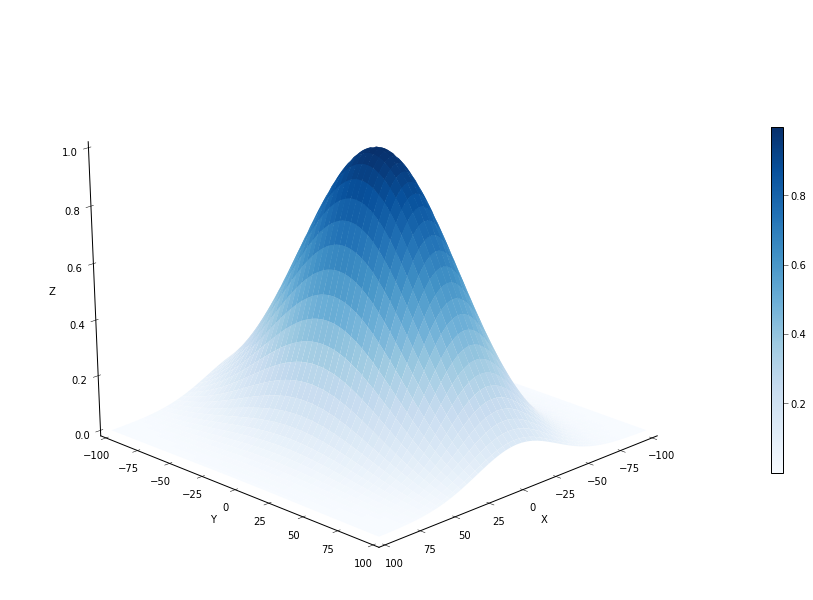

In [58]:
#Make a 3D plot
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(bottom=0,top=0.5)
ax = fig.gca(projection='3d')
im = ax.plot_surface(X, Y, rv.pdf(pos)*scale ,cmap='Blues',linewidth=0, shade=0)
ax.set_zticks([0, 0.2, 0.4, 0.6, 0.8,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(25,45)
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
fig.colorbar(im, ax=ax, shrink=0.6, aspect=30)

A nice 3D plot of Gaussian. But when it refer to the PSF of satellite images, the PSF should have an interval of satellite image pixel, basically number of pixels that gaussian covers, and we also need to think about the cutting of gaussian, since it is infinitely. Here, we use 1.96 of STD of gaussian to preserve 95% of the gaussian values. So the variances of gaussian should also control the extend of PSF as well.

In [59]:
variance_x, variance_y = 20,40
win = max(np.floor(variance_x*1.96).astype(int), np.floor(variance_y*1.96).astype(int))#use the maxium to preserved 95%
X = np.tile(np.arange(-win, win), 2*win).reshape(2*win, 2*win)# in x and y direction
Y = np.repeat(np.arange(-win, win), 2*win).reshape(2*win, 2*win)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
mu_x, mu_y = 0,0
mu_var = np.array([[variance_x**2, 0], [0, variance_y**2]])


rv = multivariate_normal([mu_x, mu_y], mu_var)
scale =  (2.*np.pi)**(rv.cov.shape[0]/2) * np.sqrt(np.linalg.det(rv.cov))

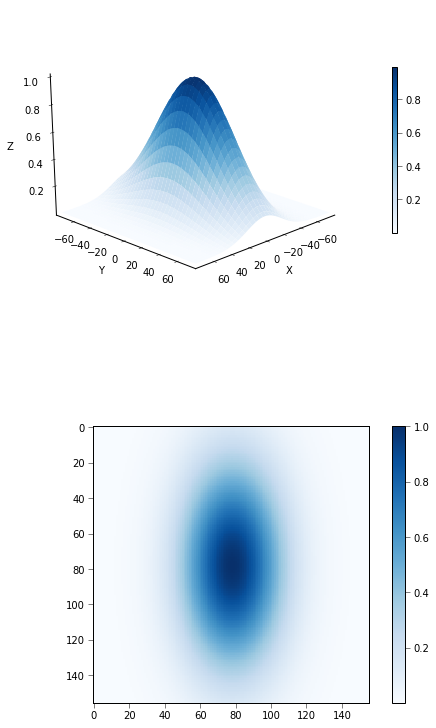

In [60]:
fig = plt.figure(figsize=(8,16))
fig.subplots_adjust(bottom=0,top=0.6)
ax = fig.add_subplot(211, projection='3d')
Z = rv.pdf(pos)
im1 = ax.plot_surface(X, Y, Z*scale ,cmap='Blues',linewidth=0, shade=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(25,45)
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
fig.colorbar(im1, ax=ax, shrink=0.6, aspect=30)
ax2 = fig.add_subplot(212)
im2 = ax2.imshow(Z*scale, vmax=(Z*scale).max()+1e-4, cmap=plt.get_cmap('Blues'))
fig.colorbar(im2, ax=ax2)

In [61]:
# another way to generate gaussian as a outer products of two direction gaussian
# we add a rotation angle as well by the affine transformation in the scipy interpoaltion module
def gaussian(xstd, ystd, angle, norm = True):
        win = 2*int(round(max(1.96*xstd, 1.96*ystd)))
        winx = int(round(win*(2**0.5)))
        winy = int(round(win*(2**0.5)))
        xgaus = signal.gaussian(winx, xstd)
        ygaus = signal.gaussian(winy, ystd)
        gaus  = np.outer(xgaus, ygaus)
        r_gaus = ndimage.interpolation.rotate(gaus, angle, reshape=True)
        center = np.array(r_gaus.shape)/2
        cgaus = r_gaus[center[0]-win/2: center[0]+win/2, center[1]-win/2:center[1]+win/2]
        if norm:
            return cgaus/cgaus.sum()
        else:
            return cgaus 

In [62]:
xstd, ystd = 40,20
gaus = gaussian(xstd, ystd, 0,0)

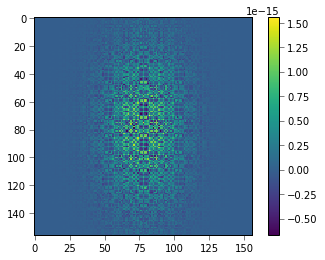

In [63]:
plt.imshow(Z*scale-gaus) # compare the two gaussian, so they are basically the same...
plt.colorbar()

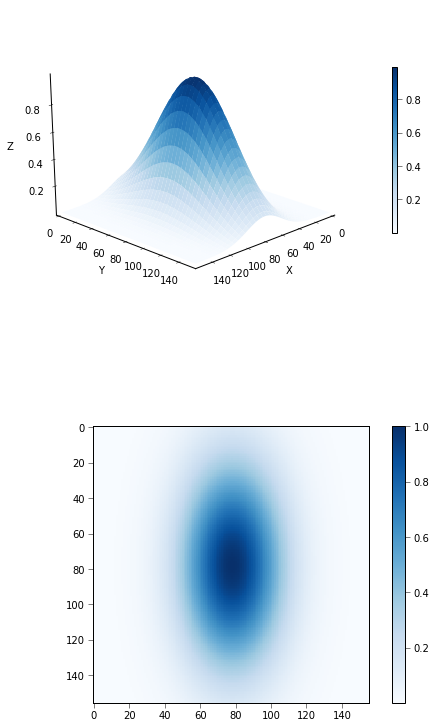

In [64]:
fig = plt.figure(figsize=(8,16))
fig.subplots_adjust(bottom=0,top=0.6)
ax = fig.add_subplot(211, projection='3d')

X = np.tile(np.arange(gaus.shape[0]), gaus.shape[0]).reshape(gaus.shape[0],gaus.shape[0])
Y = np.repeat(np.arange(gaus.shape[0]), gaus.shape[0]).reshape(gaus.shape[0],gaus.shape[0])
Z = gaus
im1 = ax.plot_surface(X, Y, Z ,cmap='Blues',linewidth=0, shade=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(25,45)
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
fig.colorbar(im1, ax=ax, shrink=0.6, aspect=30)
ax2 = fig.add_subplot(212)
im2 = ax2.imshow(Z, vmax=Z.max()+1e-4, cmap=plt.get_cmap('Blues'), interpolation='None')
fig.colorbar(im2, ax=ax2)

In [65]:
variance_x, variance_y = 20,40
win = max(np.floor(variance_x*1.96).astype(int), np.floor(variance_y*1.96).astype(int))#use the maxium to preserved 95%
X = np.tile(np.arange(-win, win), 2*win).reshape(2*win, 2*win)# in x and y direction
Y = np.repeat(np.arange(-win, win), 2*win).reshape(2*win, 2*win)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
mu_x, mu_y = 0,0
rho=0.9
mu_var = np.array([[variance_x**2, rho*variance_x*variance_y], [rho*variance_x*variance_y, variance_y**2]])

rv = multivariate_normal([mu_x, mu_y], mu_var)
scale =  (2.*np.pi)**(rv.cov.shape[0]/2) * np.sqrt(np.linalg.det(rv.cov))

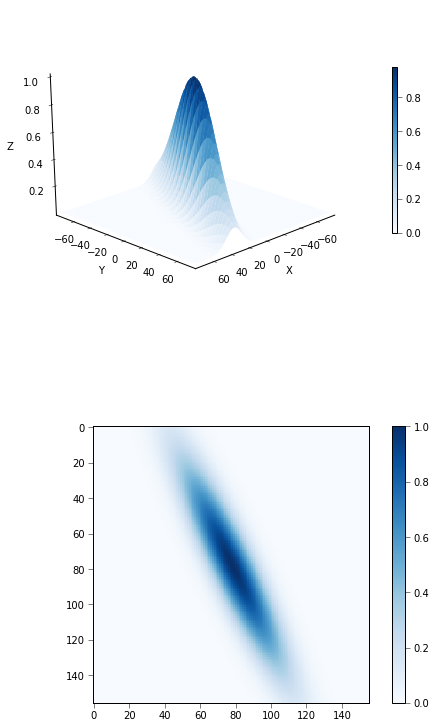

In [66]:
fig = plt.figure(figsize=(8,16))
fig.subplots_adjust(bottom=0,top=0.6)
ax = fig.add_subplot(211, projection='3d')
Z = rv.pdf(pos)
im1 = ax.plot_surface(X, Y, Z*scale ,cmap='Blues',linewidth=0, shade=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(25,45)
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
fig.colorbar(im1, ax=ax, shrink=0.6, aspect=30)
ax2 = fig.add_subplot(212)
im2 = ax2.imshow(Z*scale, vmax=(Z*scale).max()+1e-4, cmap=plt.get_cmap('Blues'))
fig.colorbar(im2, ax=ax2)

Above figues show that the rotation is not a correlation change between x and y, so we need to do use the above interpolation way to rotate our gaussian.

In [67]:
# convolve our S2 image with the PSF
s2_fname = '/home/ucfafyi/DATA/S2_MODIS/s_data/50/S/KG/2016/5/13/0/B04.jp2'
s2 = gdal.Open(s2_fname).ReadAsArray(1000,1000, 2000,2000)*0.0001

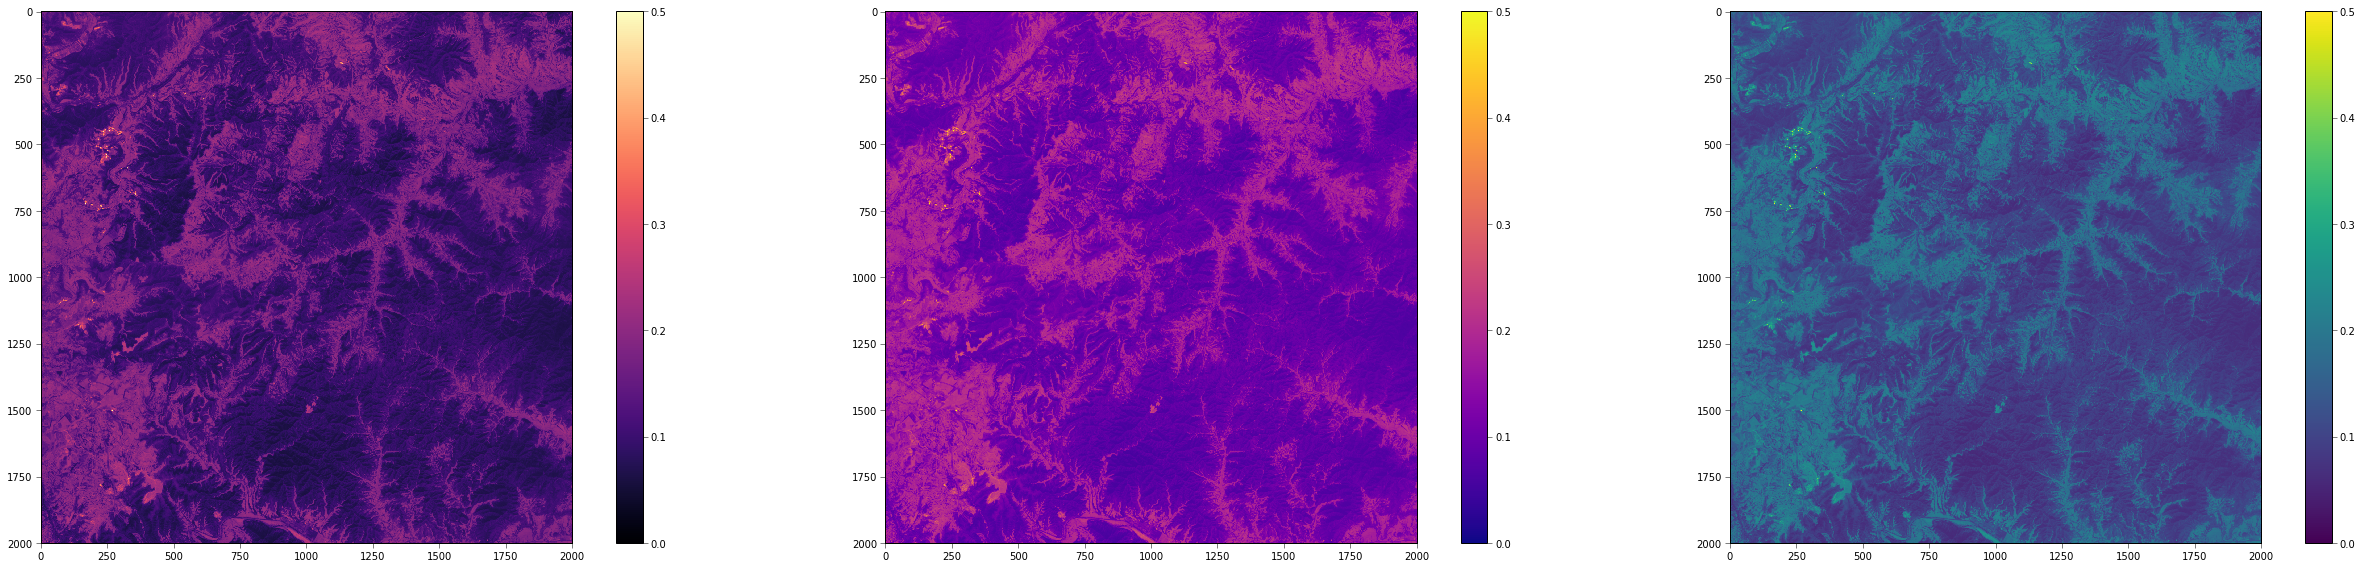

In [68]:
# just want to test different cmaps
fig = plt.figure(figsize=(12*3,8))
ax1 = fig.add_subplot(1,3,1)
im1 = ax1.imshow(s2, interpolation='None', cmap=plt.get_cmap('magma'), vmin=0, vmax=0.5)
fig.colorbar(im1, ax=ax1)
ax2 = fig.add_subplot(1,3,2)
im2 = ax2.imshow(s2, interpolation='None', cmap=plt.get_cmap('plasma'), vmin=0, vmax=0.5)
fig.colorbar(im2, ax=ax2)
ax3 = fig.add_subplot(1,3,3)
im3 = ax3.imshow(s2, interpolation='None', cmap=plt.get_cmap('viridis'), vmin=0, vmax=0.5)
fig.colorbar(im3, ax=ax3)
plt.tight_layout()

In [69]:
ker = gaussian(30,40,0, norm=1)
conved = signal.fftconvolve(s2, ker, mode='same')

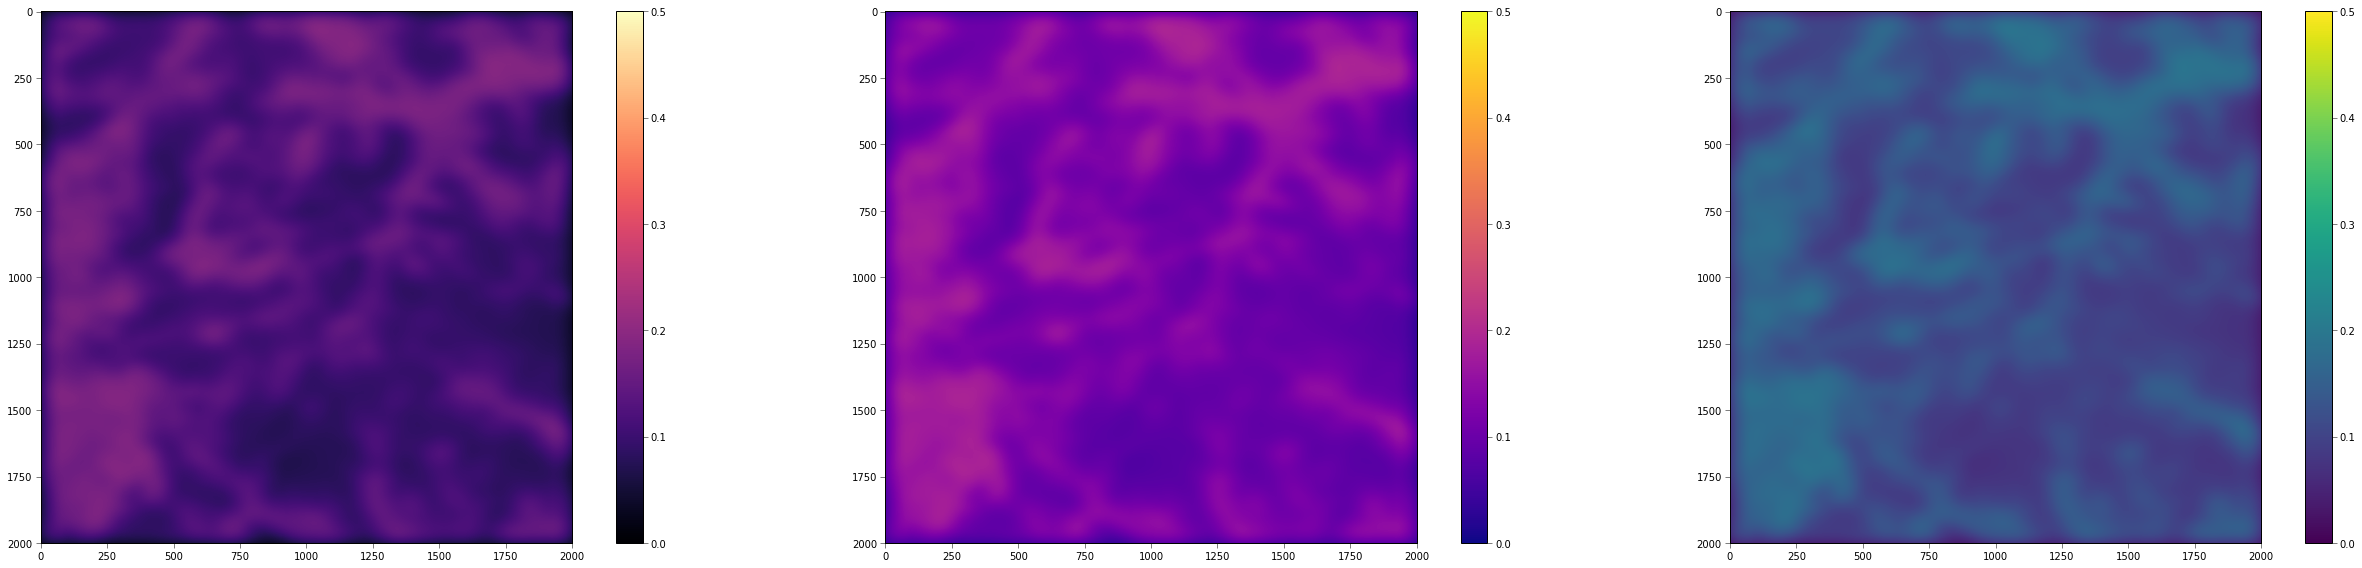

In [70]:
fig = plt.figure(figsize=(12*3,8))
ax1 = fig.add_subplot(1,3,1)
im1 = ax1.imshow(conved, interpolation='None', cmap=plt.get_cmap('magma'), vmin=0, vmax=0.5)
fig.colorbar(im1, ax=ax1)
ax2 = fig.add_subplot(1,3,2)
im2 = ax2.imshow(conved, interpolation='None', cmap=plt.get_cmap('plasma'), vmin=0, vmax=0.5)
fig.colorbar(im2, ax=ax2)
ax3 = fig.add_subplot(1,3,3)
im3 = ax3.imshow(conved, interpolation='None', cmap=plt.get_cmap('viridis'), vmin=0, vmax=0.5)
fig.colorbar(im3, ax=ax3)
plt.tight_layout()

So bascally the PSF model is a smoothing process to simulate what the low reslution sensor would see and what we need to do is to compare with MODIS captured in the time that S2 pass the same place. But that's not possible for MODIS and S2, so here we use the MODIS BRDF products and use the S2 viewing geometry to simulate a coarse resolution satellite at S2 viewing geometry at the same time as S2 passed over.

In [71]:
#read in the S2 viewing geometry
from readSent import *
import glob
import datetime
from get_brdf import *
from scipy.interpolate import griddata

In [72]:
xmlf = '/home/ucfafyi/DATA/S2_MODIS/s_data/50/S/KG/2016/5/13/0/metadata.xml'
angles = readxml(xmlf)
print angles.keys()
msa, msz, mva, mvz = angles['mSa'], angles['mSz'], angles['mVa'], angles['mVz']
angle = np.array([np.repeat(msz,13), mvz, mva - np.repeat(msa,13)])

['mVa', 'SAG_A', 'mSz', 'VIAG_A', 'SAG_Z', 'mVz', 'VIAG_Z', 'mSa']


In [73]:
s2_fname = '/home/ucfafyi/DATA/S2_MODIS/s_data/50/S/KG/2016/5/13/0/B04.jp2'

In [74]:
inds = Find_corresponding_pixels(s2_fname, destination_res=500) #GET the indexes...

In [75]:
year = int(s2_fname.split('/')[-5])
month, date = int(s2_fname.split('/')[-4]), int(s2_fname.split('/')[-3])
doy = datetime.datetime(year, month, date).timetuple().tm_yday
h,v = int(inds.keys()[1][1:3]), int(inds.keys()[1][-2:])
m_fname = glob.glob('/home/ucfafyi/DATA/S2_MODIS/m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year, doy, h, v))[0]
print h,v

27 5


In [76]:
# modis bands close to S2 bands
m_bands=[3,4,1,2,6,7]
s_bands=[1,2,3,7,11,12]

In [77]:
brdf = get_brdf_six(m_fname, angle[:,s_bands], bands = m_bands)

In [78]:
x_ind, y_ind = inds['h27v05'][1]
s2_xind, s2_yind = inds['h27v05'][0]

In [79]:
s2_coarse = np.zeros(( 10980, 10980))
s2_coarse[:] = np.nan
s2_coarse[s2_xind, s2_yind] = brdf[0][2,...][x_ind, y_ind]

In [80]:
%%time
pix_num = 10980
grid_x = np.repeat(np.arange(pix_num), pix_num).reshape(pix_num, pix_num)
grid_y = np.tile(np.arange(pix_num), pix_num).reshape(pix_num, pix_num)

CPU times: user 543 ms, sys: 384 ms, total: 927 ms
Wall time: 926 ms


In [84]:
from mgrspy import mgrs as mg
import sys
sys.path.insert(0, '/home/ucfafyi/DATA/S2_MODIS/python/')
from L_geo import *

S2_fname = '50SKG'
ll, ul, lr, ur = mg.toWgs(u'%s0000000000'%S2_fname), mg.toWgs(u'%s0000099999'%S2_fname),\
        mg.toWgs(u'%s9999900000'%S2_fname), mg.toWgs(u'%s9999999999'%S2_fname)

dic = {'LL_LAT': ll[0],
       'LL_LON': ll[1],
       'LR_LAT': lr[0],
       'LR_LON': lr[1],
       'UL_LAT': ul[0],
       'UL_LON': ul[1],
       'UR_LAT': ur[0],
       'UR_LON': ur[1]}
corners = 10000, 10000
lat, lon = 37.5, 114.5
L_inds, H_inds = MSL_geo_trans(lat, lon, dic, corners)

grid_z0 = griddata(H_inds.T, brdf[0][2,...][L_inds[0], L_inds[1]], (grid_x, grid_y), method='nearest')

In [85]:
grid_z1 = griddata((s2_xind, s2_yind), brdf[0][2,...][x_ind, y_ind], (grid_x, grid_y), method='nearest')

In [86]:
coarse_s2_ = grid_z1.reshape(pix_num, pix_num)
mas = (coarse_s2_>1)&(coarse_s2_<0)
coarse_s2_ = ma.array(coarse_s2_.data, mask = coarse_s2_.mask|mas)

In [87]:
coarse_s2 = grid_z0.reshape(pix_num, pix_num)
mas = (coarse_s2>1)&(coarse_s2<0)
coarse_s2 = ma.array(coarse_s2.data, mask = coarse_s2.mask|mas)

In [88]:
s2_fname = '/home/ucfafyi/DATA/S2_MODIS/s_data/50/S/KG/2016/5/13/0/B04.jp2'
s2 = gdal.Open(s2_fname).ReadAsArray()*0.0001

In [89]:
ker = gaussian(30,40,0, norm=1)
conved = signal.fftconvolve(s2, ker, mode='same')

/home/ucfafyi/.local/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


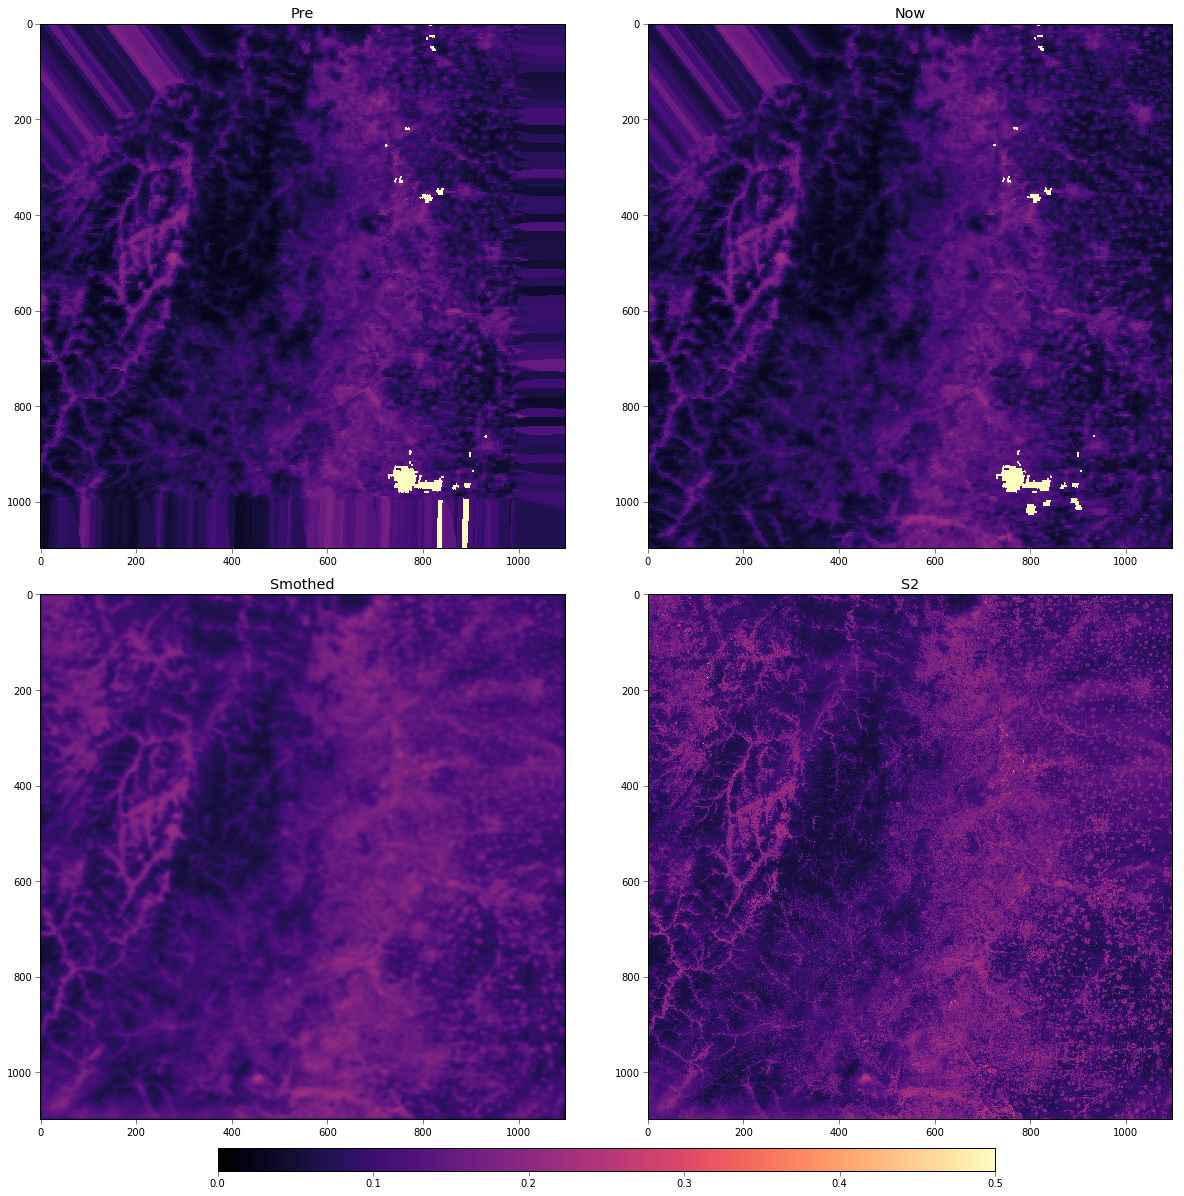

In [90]:
fig, (ax1,ax2) =plt.subplots(ncols=2, nrows=2, figsize=(18,16))
ax1[0].imshow(coarse_s2[::10,::10], interpolation='None', vmin=0,vmax=0.5, cmap='magma')
ax1[0].set_title('Pre')# rhis is the previousely defined geo_transform results
ax1[1].imshow(coarse_s2_[::10,::10], interpolation='None', vmin=0,vmax=0.5, cmap='magma')
ax1[1].set_title('Now')# this is the new one....keep the pixels out of 10000 in x and y direction
ax2[0].imshow(conved[::10,::10], interpolation='None', vmin=0,vmax=0.5, cmap='magma')
ax2[0].set_title('Smothed')
im = ax2[1].imshow(s2[::10,::10], interpolation='None', vmin=0, vmax=0.5,cmap='magma')
ax2[1].set_title('S2')
cax = fig.add_axes([0.2, -0.02, 0.6, 0.02])
fig.colorbar(im, cax=cax, orientation='horizontal')
plt.tight_layout()

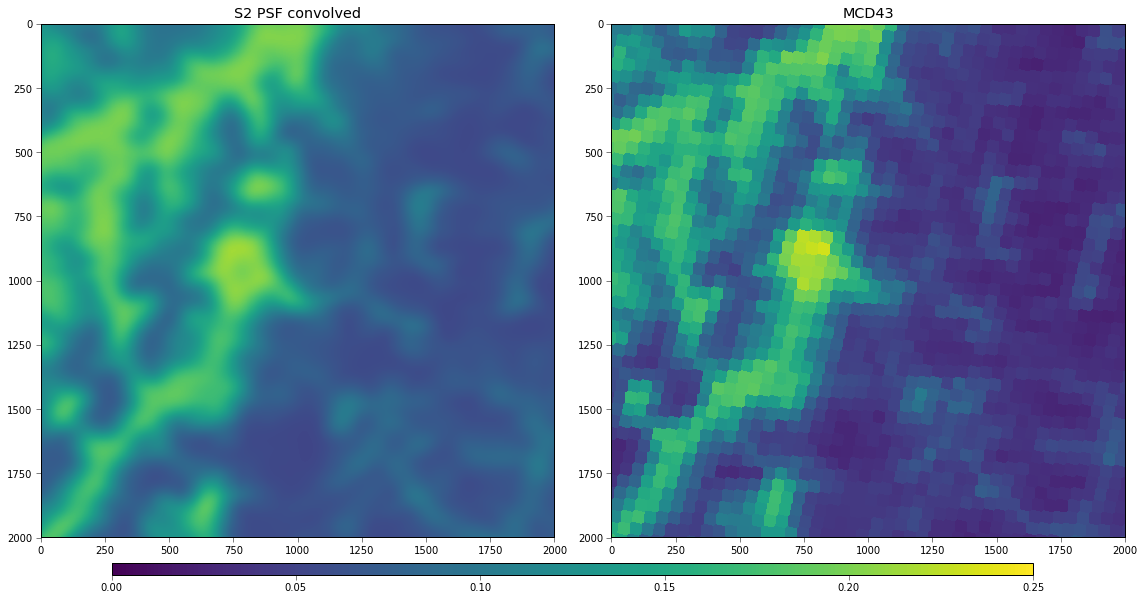

In [91]:
fig, (ax1, ax2 ) =plt.subplots(ncols=2, figsize=(16,8))
ax1.imshow(conved[4000:6000, 2000:4000], interpolation='None',  vmin=0, vmax=0.25)
ax1.set_title('S2 PSF convolved')
im = ax2.imshow(coarse_s2_[4000:6000, 2000:4000], interpolation='None', vmin=0, vmax=0.25)
ax2.set_title('MCD43')
cax = fig.add_axes([0.1, -0.01, 0.8, 0.02])
fig.colorbar(im, cax=cax, orientation='horizontal')
plt.tight_layout()

To do it in another way:

In [92]:
x_ind, y_ind = inds['h27v05'][1]
s2_xind, s2_yind = inds['h27v05'][0]

In [93]:
destination_array = np.zeros((2400,2400))
destination_array[:] = np.nan
destination_array[x_ind, y_ind] = conved[s2_xind, s2_yind]

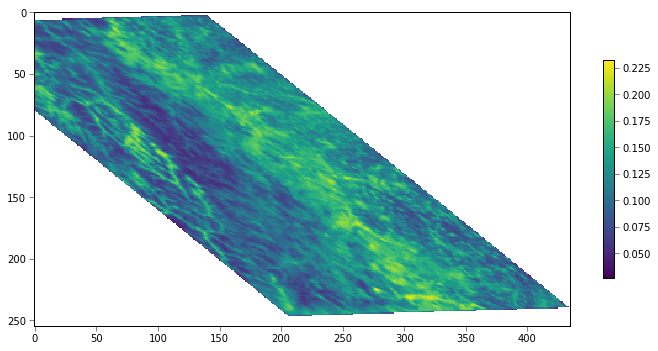

In [94]:
plt.figure(figsize= (12,8))
plt.imshow(destination_array[495:750, 0:435], interpolation='None')
plt.colorbar(shrink=0.5)

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f5759790e50>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f575966fa50>)

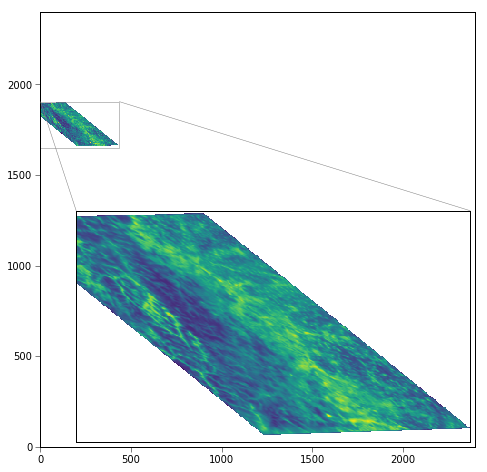

In [95]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
fig, ax = plt.subplots(figsize=[8, 8])
extent = [0, 2400, 0, 2400]
ax.imshow(destination_array, extent=extent, interpolation="nearest",
          origin="upper")

axins = zoomed_inset_axes(ax, 5, loc=4)  # zoom = 6
axins.imshow(destination_array, extent=extent, interpolation="nearest",
             origin="upper")

# sub region of the original image
x1, x2, y1, y2 = 0, 435, 2400-750, 2400-495
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# fix the number of ticks on the inset axes
#axins.yaxis.get_major_locator().set_params(nbins=7)
#axins.xaxis.get_major_locator().set_params(nbins=7)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.xaxis.set_ticks_position('none') 
axins.yaxis.set_ticks_position('none') 

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

Now we can see that it is significantly twisted when the S2 image transformed into MODIS tile and that's why in the beginning our bilinear interpolation failed to produce accurate geo-transformation.

To wrap it up...

In [96]:
def PSF_convolve(H_array, psf, H_ind, L_ind, L_res=(2400,2400)):
    '''A function spedified for the PSF convolution
    args:
        H_array--Hight resolution image array
        psf--2D array of PSF
        H_ind, L_ind--the indexs of H_array corresponding to L_array with different projection
        L_res--the resolution of output array, should be consitent with the indexes..
    return:
        L_array--convolved results in the Low resolution image projection
    
    '''
    conved = signal.fftconvolve(H_array, psf, mode='same')
    L_array = np.zeros(L_res)
    L_array[:] = np.nan
    L_array[L_ind[0], L_ind[1]] = conved[H_ind[0], H_ind[1]]
    return L_array

Adding cloud masks...

In [97]:
cloud = gdal.Open('cloud.png').ReadAsArray()

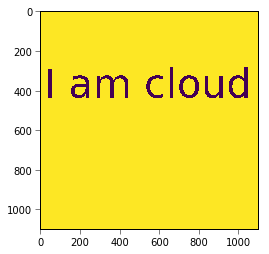

In [98]:
plt.imshow(cloud[::10,::10])

In [99]:
cloud_mask = cloud!=0

In [100]:
%%time
conved_cloud = signal.fftconvolve(cloud_mask, ker, mode='same')

CPU times: user 15.3 s, sys: 4.2 s, total: 19.5 s
Wall time: 19.5 s


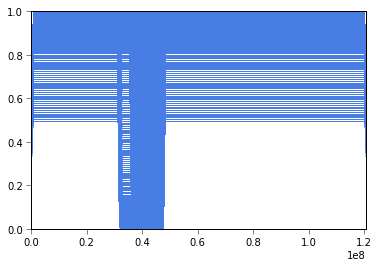

In [101]:
plt.plot(conved_cloud.ravel(), 'o', ms=0.5)

This give us an indication that it is hard to define the pure pixels after convolution....

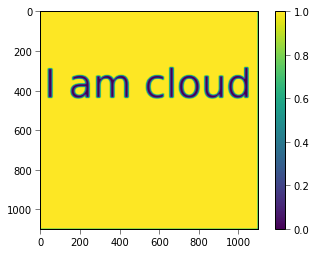

In [102]:
plt.imshow(conved_cloud[::10,::10], interpolation='None')
plt.colorbar()

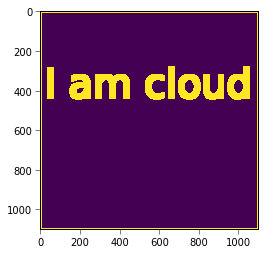

In [103]:
conved_cloud_mask = conved_cloud<(1-0.00000001)# we try to do this way, but still too albitrary
plt.imshow(conved_cloud_mask[::10,::10], interpolation='None')

Now our new cloud mask is the original mask dialated with the border pixels are flagged out.

To be able to find out those pure pxiels, we use a dilation process using the coverage of PSF model to find out the exact pixels that would included by the PSF convolution process.

In [104]:
cloud[0,:]=cloud[-1,:]=cloud[:,0]=cloud[:,-1]=0# to mask out the border as well
cloud

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 255, 255, ..., 255, 255,   0],
       [  0, 255, 255, ..., 255, 255,   0],
       ..., 
       [  0, 255, 255, ..., 255, 255,   0],
       [  0, 255, 255, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [105]:
%%time
xstd, ystd = 30,40
win = 2*int(round(max(1.96*xstd, 1.96*ystd)))
struct = np.ones((3,3)).astype(bool)
b = ndimage.binary_dilation(cloud==0, structure=struct, iterations=win/2).astype(bool)

CPU times: user 3.17 s, sys: 66.1 ms, total: 3.23 s
Wall time: 3.23 s


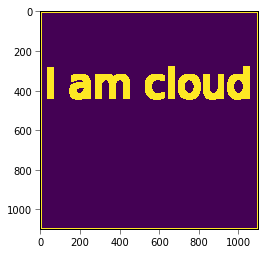

In [106]:
plt.imshow(b[::10,::10], interpolation='None')

/home/ucfafyi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  if __name__ == '__main__':


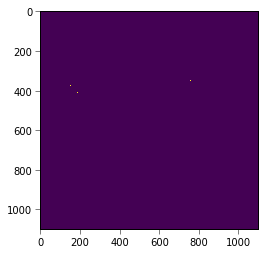

In [107]:
plt.imshow((conved_cloud_mask-b)[::10,::10], interpolation='None')

The are almost the same, but...

In [108]:
(conved_cloud_mask*1.-b*1.).sum()

-91825.0

The cloud mask convoled with PSF is hard to define the boarder, since the differences between the values are maginal and its hard to define which one is pure after the convolution. And actually the binary dilation process is faster than the convolution process, so the dilation is used to find out those pure pixels instead of convolution of PSF and cloud mask.

In [109]:
def cloud_dilation(cloud_mask, iteration=1):
    '''
    A function for the dilation of cloud mask
    
    '''
    struct = np.ones((3,3)).astype(bool)
    dila_cloud = ndimage.binary_dilation(cloud_mask, structure=struct, iterations=iteration).astype(bool)
    return dila_cloud
    
xstd, ystd = 30,40
win = 2*int(round(max(1.96*xstd, 1.96*ystd)))
dila_cloud = cloud_dilation(cloud==0, iteration=win/2)

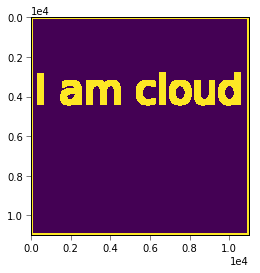

In [110]:
plt.imshow(dila_cloud, interpolation='None')

In [111]:
#To see it in MODIS projection
L_res=(2400, 2400)
mask = np.zeros(L_res).astype(bool)
mask[x_ind, y_ind] = dila_cloud[s2_xind, s2_yind]

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f5759385cd0>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f5759330d10>)

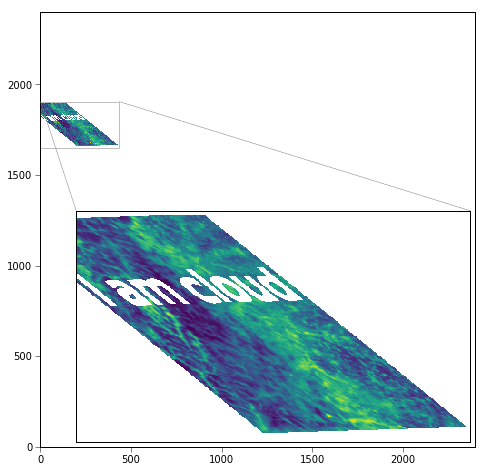

In [112]:
fig, ax = plt.subplots(figsize=[8, 8])
extent = [0, 2400, 0, 2400]
destination_array = ma.array(destination_array, mask=mask)
ax.imshow(destination_array, extent=extent, interpolation="nearest",
          origin="upper")

axins = zoomed_inset_axes(ax, 5, loc=4)  # zoom = 6
axins.imshow(destination_array, extent=extent, interpolation="nearest",
             origin="upper")

# sub region of the original image
x1, x2, y1, y2 = 0, 435, 2400-750, 2400-495
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# fix the number of ticks on the inset axes
#axins.yaxis.get_major_locator().set_params(nbins=7)
#axins.xaxis.get_major_locator().set_params(nbins=7)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.xaxis.set_ticks_position('none') 
axins.yaxis.set_ticks_position('none') 

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

So now we can see the PSF modeled with the MCD43 have prety much the same kind of parten. But what we need to do now is the get the optimized parameters for the PSF model, and we need a criteria for the goodness of fitting between them. Since the MCD43 is the BRDF modeled surdface reflectance and our S2 is the TOA reflectance, which means we cannot simply use the difference between them, we introduce the correlation between them.

So now we have done all of the parts for the spatial mapping.....

In [113]:
# a demonstration of the usage
s2_fname = '/home/ucfafyi/DATA/S2_MODIS/s_data/50/S/KG/2016/5/13/0/B04.jp2'
tiles = Find_corresponding_pixels(s2_fname, destination_res=500)
print 'There are %d MODIS tiles covered by this high resolution image.'%len(tiles), '\n', 'Thay are %s and %s'%(tiles.keys()[0],tiles.keys()[1])

There are 2 MODIS tiles covered by this high resolution image. 
Thay are h26v05 and h27v05


In [114]:
g = gdal.Open(s2_fname)
H_array = g.ReadAsArray()
cloud = gdal.Open('cloud.png').ReadAsArray()

xstd, ystd = 30,40
ker = gaussian(xstd, ystd, 0)
size = 2*int(round(max(1.96*xstd, 1.96*ystd)))
# or you want a flat kernel
size = 150
k = np.ones((size, size))
ker1 = k/k.sum()


H_ind, L_ind = tiles['h27v05']# test with h27vo5 tile

L_res=(2400, 2400)
L_array = PSF_convolve(H_array, ker, H_ind, L_ind, L_res=L_res)
dila_cloud = cloud_dilation(cloud==0, iteration=size/2)
mask = np.zeros(L_res).astype(bool)
mask[L_ind[0], L_ind[1]] = dila_cloud[H_ind[0], H_ind[1]]
destination_array = ma.array(L_array, mask=mask)

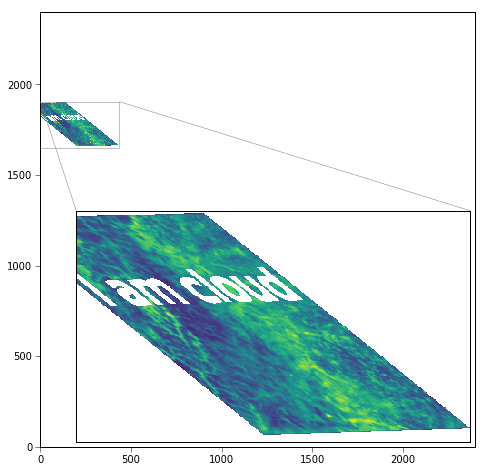

In [115]:
fig, ax = plt.subplots(figsize=[8, 8])
extent = [0, 2400, 0, 2400]
ax.imshow(destination_array, extent=extent, interpolation="nearest",
          origin="upper")

axins = zoomed_inset_axes(ax, 5, loc=4)  # zoom = 6
axins.imshow(destination_array, extent=extent, interpolation="nearest",
             origin="upper")

# sub region of the original image
x1, x2, y1, y2 = 0, 435, 2400-750, 2400-495
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# fix the number of ticks on the inset axes
#axins.yaxis.get_major_locator().set_params(nbins=7)
#axins.xaxis.get_major_locator().set_params(nbins=7)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.xaxis.set_ticks_position('none') 
axins.yaxis.set_ticks_position('none') 

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
_ =mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

Producing the same results like previously..... 

#### Functions

In [116]:
from scipy import ndimage, signal
import numpy.ma as ma
def gaussian(xstd, ystd, angle, norm = True):
        win = 2*int(round(max(1.96*xstd, 1.96*ystd)))
        winx = int(round(win*(2**0.5)))
        winy = int(round(win*(2**0.5)))
        xgaus = signal.gaussian(winx, xstd)
        ygaus = signal.gaussian(winy, ystd)
        gaus  = np.outer(xgaus, ygaus)
        r_gaus = ndimage.interpolation.rotate(gaus, angle, reshape=True)
        center = np.array(r_gaus.shape)/2
        cgaus = r_gaus[center[0]-win/2: center[0]+win/2, center[1]-win/2:center[1]+win/2]
        if norm:
            return cgaus/cgaus.sum()
        else:
            return cgaus 
def PSF_convolve(H_array, psf, H_ind, L_ind, L_res=(2400,2400)):
    '''A function spedified for the PSF convolution
    args:
        H_array--Hight resolution image array
        psf--2D array of PSF
        H_ind, L_ind--the indexs of H_array corresponding to L_array with different projection
        L_res--the resolution of output array, should be consitent with the indexes..
    return:
        L_array--convolved results in the Low resolution image projection
    
    '''
    conved = signal.fftconvolve(H_array, psf, mode='same')
    L_array = np.zeros(L_res)
    L_array[:] = np.nan
    L_array[L_ind[0], L_ind[1]] = conved[H_ind[0], H_ind[1]]
    return L_array
def cloud_dilation(cloud_mask, iteration=1):
    '''
    A function for the dilation of cloud mask
    
    '''
    struct = np.ones((3,3)).astype(bool)
    dila_cloud = ndimage.binary_dilation(cloud_mask, structure=struct, iterations=iteration).astype(bool)
    return dila_cloud
    